Imports. Ensure that the `main_functions.py` file is correclty imported 

In [15]:
import pygsti
import pygsti.modelmembers as mm
import numpy as np
from math import pi
from main_functions import *

Let's begin with the model definition. We build an explicit model and add custome operations to impose the parametrization in the coloured phase model. To know more about this check the `CustomeOperator.ipynb` tutorial availible at pyGSTi docs. First, we need to define the operator class to add gates to the model

In [2]:
#operator class for the gate

class G(pygsti.modelmembers.operations.DenseOperator):

    def __init__(self, markov_approx, pulse_duration, phase, representation, gate_index):
        #initialize with no noise
        super(G, self).__init__(np.identity(4,'d'), 'pp', "densitymx_slow") # this is *super*-operator, so "densitymx"
        
        self.markov_approx = markov_approx
        self.pulse_duration = pulse_duration
        self.phase = phase
        self.representation = representation
        self.gate_index = gate_index

        if self.markov_approx:
            self.from_vector([0, 1e-8]) #Small value to avoid divison by zero 
        else:
            self.from_vector([0, 1e-8, 0, 0]) #Small value to avoid divison by zero 
    
    #return the number of parameters
    @property
    def num_params(self):

        if self.markov_approx:
            return 2
        else:
            return 4

    #return the labels of the parameters
    @property
    def parameter_labels(self):

        if self.markov_approx:
            return [ (f'G{self.gate_index} param1'),
                     (f'G{self.gate_index} param2')]
        else:
            return [ (f'G{self.gate_index} param1'),
                    (f'G{self.gate_index} param2'),
                    (f'G{self.gate_index} param3'),
                    (f'G{self.gate_index} param4')]

    #parameter bounds
    @property
    def parameter_bounds(self): #\Gamma_1 > 0 to ensure complete positivity of the matrices

        if self.markov_approx:
            return [(0, np.inf),
                    (-np.inf, np.inf)]
        else:
            return [(0, np.inf),
                    (-np.inf, np.inf),
                    (-np.inf, np.inf),
                    (-np.inf, np.inf)]
    
    def to_vector(self):

        if self.markov_approx:
            return np.array([self.Gamma_1, self.Delta_1],'d')
        else:
            return np.array([self.Gamma_1, self.Delta_1, self.Gamma_2, self.Delta_2],'d') #our parameter vector
        
    def from_vector(self, v, close=False, dirty_value=True):

        #initialize from parameter vector v
        self.Gamma_1 = v[0]
        self.Delta_1 = v[1]

        if self.markov_approx:
            self.Gamma_2 = 0
            self.Delta_2 = 0
        else:
            self.Gamma_2 = v[2]
            self.Delta_2 = v[3]
        
        # ._ptr is a member of DenseOperator and is a numpy array that is 
        # the dense Pauli transfer matrix of this operator
        # Technical note: use [:,:] instead of direct assignment so id of self._ptr doesn't change
        # self._ptr[:,:] = build_gate_ptm(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),
        #                                 self.pulse_duration, self.markov_approx, phase = self.phase)
        
        self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),
                                    self.pulse_duration, self.markov_approx, representation = self.representation, phase = self.phase)

        self.dirty = dirty_value  # mark that parameter vector may have changed

Now we can add custom operations to define our gate set

In [3]:
#For this tutorial we will use the Markov approximation, so that \Gamma_2 = \Delta_2 = 0.
markov_approx = True

#Explicit model
mdl = pygsti.models.ExplicitOpModel(['Q0'],'pp')

#We add the initial state. It is constrained to be trace preserving
mdl['rho0'] = mm.states.TPState( np.array([ 1/sqrt(2), 0, 0, 1/sqrt(2) ], 'd'), 
                                       evotype = 'densitymx_slow') # density matrix [[1, 0], [0, 0]] in Pauli basis


#We also add a physical measurement operator with two effects.
mdl['Mdefault'] = mm.povms.TPPOVM(
    {'0': [ 1/sqrt(2), 0, 0, 1/sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
     '1': [ 1/sqrt(2), 0, 0, -1/sqrt(2) ] },# projector onto [[0, 0], [0, 1]] in Pauli basis
    evotype = 'densitymx_slow') # Specify the evolution type when initializing from NumPy arrays.
                                # densitymx is the default


# We add the operations of the chosen gate set to the model

myGates = ['G1', 'G2', 'G3', 'G4', 'G5']
gateSetParams = {'G1': [np.pi, 0], 
                 'G2': [np.pi / 2, 0],
                 'G3': [np.pi / 2, np.pi / 2],
                 'G4': [np.pi / 2, np.pi],
                 'G5': [np.pi / 2, 3 * np.pi / 2]}

for idx, gate in enumerate(myGates):
    mdl[gate] = G(markov_approx, *gateSetParams[gate], 'PTM', idx + 1)

#print the model
print(mdl)


rho0 = TPState with dimension 4
 0.71   0   0 0.71


Mdefault = TPPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: ComplementPOVMEffect with dimension 4
 0.71   0   0-0.71



G1 = 
G with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0-1.00   0
   0   0   0-1.00


G2 = 
G with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0-1.00
   0   0 1.00   0


G3 = 
G with shape (4, 4)
 1.00   0   0   0
   0   0   0-1.00
   0   0 1.00   0
   0 1.00   0   0


G4 = 
G with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0 1.00
   0   0-1.00   0


G5 = 
G with shape (4, 4)
 1.00   0   0   0
   0   0   0 1.00
   0   0 1.00   0
   0-1.00   0   0






/var/folders/ws/1_wx4s_x7758p_wqvc9n4yf40000gn/T/ipykernel_10294/3308610479.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),


Now, we know from the theoretical model that gates with same pusle duration should be represented with the same set of parameters. We can implement this by  making use of the `collect_parameters()` method, as described in the `ParameterLabels.ipynb` tutorial. However, first we need to rebuild the paramvec, as this is not an automated process when defining the gate set. In the markovian case, the number of free parameters should be 11.

In [4]:
#rebuild the param vector
mdl._rebuild_paramvec()

#collect the parameters
mdl.collect_parameters([('G2', 'G2 param1'),
                        ('G3', 'G3 param1'),
                        ('G4', 'G4 param1'),
                        ('G5', 'G5 param1')],
                        new_param_label = 'Gamma_1 pulse = pi/2')

mdl.collect_parameters([('G2', 'G2 param2'),
                        ('G3', 'G3 param2'),
                        ('G4', 'G4 param2'),
                        ('G5', 'G5 param2')],
                        new_param_label = 'Delta_2 pulse = pi/2')

if not markov_approx:
    mdl.collect_parameters([('G2', 'G2 param3'),
                            ('G3', 'G3 param3'),
                            ('G4', 'G4 param3'),
                            ('G5', 'G5 param3')],
                            new_param_label = 'Gamma_2 pulse = pi/2')

    mdl.collect_parameters([('G2', 'G2 param4'),
                            ('G3', 'G3 param4'),
                            ('G4', 'G4 param4'),
                            ('G5', 'G5 param4')],
                            new_param_label = 'Delta_2 pulse = pi/2')

print(mdl.parameter_labels)
print(mdl.num_params)

[(Label('rho0'), 'VecElement 1') (Label('rho0'), 'VecElement 2')
 (Label('rho0'), 'VecElement 3') (Label('Mdefault'), 'VecElement Re(0)')
 (Label('Mdefault'), 'VecElement Re(1)')
 (Label('Mdefault'), 'VecElement Re(2)')
 (Label('Mdefault'), 'VecElement Re(3)') (Label('G1'), 'G1 param1')
 (Label('G1'), 'G1 param2') 'Gamma_1 pulse = pi/2' 'Delta_2 pulse = pi/2']
11


/var/folders/ws/1_wx4s_x7758p_wqvc9n4yf40000gn/T/ipykernel_10294/3308610479.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),


Now that we have defined the theoretical model for our gate set, it is time to simulate data to perform GST. To do so, we create an "experimental_model" which will act as the noisy operations taking place in the device.

In [5]:
#Define some noise parameters for the OU noise
omega, tau, c = 1.2566 * 1e3, 5 * 1e-6, 2 * 1e5

#params of the noisy operations
gs_params = np.array([[pi, 0],[pi/2, 0],[pi/2, pi/2], [pi/2, pi], [pi/2, 3 * pi/2]])

noise_params = np.array([omega, tau, c])
#The availible faulty inital state parameters
state_params = np.array([1e-1, 1e-1, 0.95])
#The availible faulty measurement operator parameters
measurement_params = np.array([1, 1e-1, 1e-1, 0.95])

#We use the `gate_set_noise_params`class to define the experimental gate set
Gate_set = gate_set_noise_params(noise_params, state_params, measurement_params, 1, markov_approx, 'PTM', gs_params)

#explicit model definition
experimental_mdl = pygsti.models.ExplicitOpModel(['Q0'],'pp')

#model state
experimental_mdl['rho0'] = Gate_set.state()

#model measurement
experimental_mdl['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set.measurement()},
    evotype='densitymx_slow')


# Option 1: simulate the date with gates parameterized with the coloured phase model. We would therefore perform tomography with data 
# which we are sure that can fit to the theoretical model. This is used for research purposes to test the performance of the model.

# for idx, gate in enumerate(myGates):
#     experimental_mdl[gate] = Gate_set.gates()[idx]

# Option 2: simulate the date with gates obtained averaging over many noisy instances. This does not make any approximation and it is
# a more realistic scenario.

#Number of stochastic instances
Mnoise = 1e3 #Only for testing purpouses. To have an acceptable accuracy set at least Mnoise = 1e4

for idx, gate in enumerate(myGates):
    mdl[gate] = G(markov_approx, *gateSetParams[gate], 'PTM', idx + 1)
    experimental_mdl[gate] = chi2ptm(stochastic_matrices([gs_params[idx, 1]], Mnoise, gs_params[idx, 0], c, tau, omega)[0])

/var/folders/ws/1_wx4s_x7758p_wqvc9n4yf40000gn/T/ipykernel_10294/3308610479.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),


We seleect the base circuits and fiducial pairs that we shall employ to perform GST. From the theory we know that single gates serve as an amplificationally complete set when working under this parameterization. Additionally, for each parameter, we select the fiducial pair which stimulates it the most.  

In [6]:
# operations for SPAM and germs
prep_fiducials = pygsti.circuits.to_circuits(['G1', 'G2', 'G3', 'G4', 'G5'])
meas_fiducials = pygsti.circuits.to_circuits(['G1', 'G2', 'G3', 'G4', 'G5'])
germs = pygsti.circuits.to_circuits(['G1', 'G2', 'G3', 'G4', 'G5'])

#We select the fiducial pairs which stimulate the most the parameters
fidPairs = {pygsti.circuits.Circuit('G1'): [(0,0),(0,2),(0,3),(0,4)], pygsti.circuits.Circuit('G2'): [(0,4)],
            pygsti.circuits.Circuit('G3'): [(0,0)], pygsti.circuits.Circuit('G4'): [(0,0), (0,3), (4,4)],
            pygsti.circuits.Circuit('G5'): [(0,4),(4,4)]}

# list of max lengths for long-sequence circutis
maxLengths = [1, 2, 4, 8, 16]

# the list of experiments to execute
listOfExperiments = pygsti.circuits.gstcircuits.create_lsgst_circuits(
    myGates, prep_fiducials, meas_fiducials, germs, maxLengths, fidPairs, include_lgst = False)


Data simulation

In [7]:
#shots to obtain experimental frequencies for each circuit
shots = 1e7

#simulate the data
data = pygsti.data.simulate_data(experimental_mdl, listOfExperiments, num_samples = shots,
                                         sample_error = 'binomial')

/Users/pablovinasmartinez/opt/anaconda3/envs/coloured_GST/lib/python3.12/site-packages/pygsti/models/model.py:974: ComplexWarning: Casting complex values to real discards the imaginary part
  w[obj.gpindices] = obj.to_vector()
/Users/pablovinasmartinez/opt/anaconda3/envs/coloured_GST/lib/python3.12/site-packages/pygsti/forwardsims/matrixforwardsim.py:746: ComplexWarning: Casting complex values to real discards the imaginary part
  prodCache[iDest] = gate / nG


We fit using long sequence GTS. We do not need to perfrom gauge optimisation because there is not gauge freedom with our parameterization.

In [8]:
#some custom GST options
my_adv_options = {'tolerance': 1e-6, 'starting_point': 'target', 'max_iterations': 1000}

#run lsGST
results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                           germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 1)
                                           

#We define a model with the results
mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']

--- Circuit Creation ---


/var/folders/ws/1_wx4s_x7758p_wqvc9n4yf40000gn/T/ipykernel_10294/3308610479.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),


--- Iterative GST: [##################################################] 100.0%  55 circuits ---


Let's compare the resutls

In [9]:
G_estimate, G_experimental = mdl_estimate['G1'].to_dense(), experimental_mdl['G1'].to_dense()

print(G_estimate)
print(G_experimental)

print(pygsti.tools.tracedist(mdl_estimate['G1'].to_dense(), experimental_mdl['G1'].to_dense()))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.99970429e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99985215e-01 -7.62984112e-06]
 [ 0.00000000e+00  0.00000000e+00  7.62984112e-06 -9.99985215e-01]]
[[ 1.00000000e+00+0.j  4.23516474e-22+0.j -2.73392426e-18+0.j
   0.00000000e+00+0.j]
 [ 3.60525016e-22+0.j  9.99999983e-01+0.j -2.61686895e-06+0.j
   6.18559124e-06+0.j]
 [ 2.73392404e-18+0.j -2.61686901e-06+0.j -9.99999992e-01+0.j
  -7.46939720e-11+0.j]
 [ 0.00000000e+00+0.j  6.18559126e-06+0.j  1.84732935e-10+0.j
  -9.99999992e-01+0.j]]
3.231342127108514e-05


To see if GST recovers the right parameters, let us use data simulated with the parameterized model (Option 1 in the experimental model cell). To make sure everything works, we will use a **very noisy** model.

In [10]:
#Define some noise parameters for the OU noise
omega, tau, c = 1.2566 * 1e3, 5 * 1e-4, 2 * 1e9

#params of the noisy operations
gs_params = np.array([[pi, 0],[pi/2, 0],[pi/2, pi/2], [pi/2, pi], [pi/2, 3 * pi/2]])

noise_params = np.array([omega, tau, c])
#The availible faulty inital state parameters
state_params = np.array([1e-1, 1e-1, 0.95])
#The availible faulty measurement operator parameters
measurement_params = np.array([1, 1e-1, 1e-1, 0.95])

#We use the `gate_set_noise_params`class to define the experimental gate set
Gate_set = gate_set_noise_params(noise_params, state_params, measurement_params, 1, markov_approx, 'PTM', gs_params)

#explicit model definition
experimental_mdl = pygsti.models.ExplicitOpModel(['Q0'],'pp')

#model state
experimental_mdl['rho0'] = Gate_set.state()

#model measurement
experimental_mdl['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set.measurement()},
    evotype='densitymx_slow')

for idx, gate in enumerate(myGates):
    experimental_mdl[gate] = Gate_set.gates()[idx]

#shots to obtain experimental frequencies for each circuit
shots = 1e3

#simulate the data
data = pygsti.data.simulate_data(experimental_mdl, listOfExperiments, num_samples = shots,
                                         sample_error = 'binomial')

#run lsGST
results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                           germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 1)     

#We define a model with the results
mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']                                   

--- Circuit Creation ---


/var/folders/ws/1_wx4s_x7758p_wqvc9n4yf40000gn/T/ipykernel_10294/3308610479.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),


--- Iterative GST: [##################################################] 100.0%  55 circuits ---


We compare the parameters. We get some shot noise, but recover the correct set.

In [11]:
G_estimate, G_experimental = mdl_estimate['G1'].to_dense(), experimental_mdl['G1'].to_dense()
vec_estimate, vec_experimental = mdl_estimate['G1'].to_vector(), quantum_channel(pi, omega, tau, c, p = 1, markovian_approx = markov_approx, representation = 'PTM', phase = 0)[1:]

print(vec_estimate)
print(vec_experimental)

[0.38855562 0.16665183]
(0.40896673960965435, 0.20026551703634543, 0.0, 0.0)


We finally also compare the gates

In [12]:
print(G_estimate)
print(G_experimental)

print(pygsti.tools.tracedist(mdl_estimate['G1'].to_dense(), experimental_mdl['G1'].to_dense()))

[[ 1.          0.          0.          0.        ]
 [ 0.          0.67803551  0.          0.        ]
 [ 0.          0.         -0.82057215  0.06853361]
 [ 0.          0.         -0.06853361 -0.82057215]]
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.66433633+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.81098554+0.j  0.08147872+0.j]
 [ 0.        +0.j  0.        +0.j -0.08147872+0.j -0.81098554+0.j]]
0.022957934743977823


Lastly, we will progressively increase the number of shots to reproduce Fig. 3 of the paper. We select an interval of shots ranging in $N_{\rm b,s}\in [10^2-10^7]$. We repeat the experiment 10 times to limit the variance.

In [13]:
#This will take some minutes

#Define some noise parameters for the OU noise
omega, tau, c = 1.2566 * 1e3, 5 * 1e-4, 2 * 1e9

#We use the `gate_set_noise_params`class to define the experimental gate set
Gate_set = gate_set_noise_params(noise_params, state_params, measurement_params, 1, markov_approx, 'PTM', gs_params)

#explicit model definition
experimental_mdl = pygsti.models.ExplicitOpModel(['Q0'],'pp')

#model state
experimental_mdl['rho0'] = Gate_set.state()

#model measurement
experimental_mdl['Mdefault'] = pygsti.modelmembers.povms.UnconstrainedPOVM(
    {'0': Gate_set.measurement(),  
     '1': [ sqrt(2), 0, 0, 0 ] - Gate_set.measurement()},
    evotype='densitymx_slow')

for idx, gate in enumerate(myGates):
    experimental_mdl[gate] = Gate_set.gates()[idx]




shots_array = np.logspace(2,7,10)

#To obtain accurate results we should set iterations = 100
iterations = 10

results_array = np.empty([len(shots_array), iterations])

for idx, shots in enumerate(shots_array):

    for iter in range(iterations): 
    
        #simulate the data
        data = pygsti.data.simulate_data(experimental_mdl, listOfExperiments, num_samples = shots,
                                                sample_error = 'binomial')

        #run lsGST
        results = pygsti.run_long_sequence_gst(data, mdl, prep_fiducials, meas_fiducials,
                                                germs, maxLengths, gauge_opt_params = False, advanced_options = my_adv_options, verbosity = 0)     

        #We define a model with the results
        mdl_estimate = results.estimates['GateSetTomography'].models['final iteration estimate']   

        results_array[idx, iter] = pygsti.tools.tracedist(mdl_estimate['G1'].to_dense(), experimental_mdl['G1'].to_dense())

/var/folders/ws/1_wx4s_x7758p_wqvc9n4yf40000gn/T/ipykernel_10294/3308610479.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  self._ptr[:,:] = build_gate(np.array([self.Gamma_1, self.Delta_1,  self.Gamma_2,  self.Delta_2], 'd'),







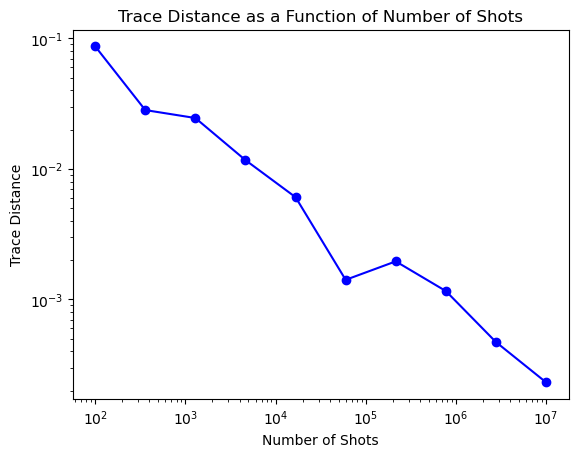

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#we average ethe results over the iterations
trace_distances = results_array.mean(axis = 1)

# Creating the log-log plot
plt.loglog(shots_array, trace_distances, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Number of Shots')
plt.ylabel('Trace Distance')
plt.title('Trace Distance as a Function of Number of Shots')

# Display the plot
plt.show()

If we repeat this experiment many times, we should obtain a slope close to -0.5. This can be already appreciated in the graph above for just 10 iteration.